Uvod
Ovaj projekat demonstrira proces klasifikacije slika koristeći konvolucijsku neuronsku mrežu (CNN). Projekat je implementiran koristeći TensorFlow, visoko-nivojsku biblioteku za duboko učenje. Cilj projekta je da se izgradi model koji može automatski da klasifikuje slike u definisane kategorije.

Postavka Projekta
Podaci
Podaci se sastoje od slika podeljenih u različite kategorije. Slike su smeštene unutar direktorijuma nazvanog 'test'. Svaka kategorija slika smeštena je u sopstveni poddirektorijum.

Parametri
Za obradu slika koristimo sledeće parametre:

batch_size: 32 - Broj slika koje se procesiraju u jednoj grupi (batch).
img_height i img_width: 256 - Dimenzije na koje se slike skaliraju pre obrade.
Podela Podataka
Podaci su podeljeni na tri skupa:

Trening skup: Koristi se za učenje modela.
Validacioni skup: Koristi se za podešavanje parametara modela i prevenciju preprilagođavanja.
Test skup: Koristi se za ocenjivanje finalne performanse modela.
Model
Model koji koristimo je konvolucijska neuronska mreža koja se sastoji od tri konvolucijska sloja, svaki praćen max-pooling slojem, zatim jednog sloja za izravnavanje (Flatten) i dva guste (Dense) sloja. Model je kompilovan sa Adam optimizatorom, funkcijom gubitka SparseCategoricalCrossentropy i metrikom tačnosti (accuracy).

Treniranje Modela
Model se trenira na trening skupu uz validaciju na validacionom skupu kroz 10 epoha. Progres treniranja se prati putem tačnosti (accuracy) i gubitka (loss) na oba skupa.

Korišćenje Koda
Kod se može koristiti za treniranje modela za klasifikaciju slika. Nakon treniranja, model je spreman za evaluaciju na test skupu kako bi se utvrdila njegova tačnost

In [1]:
import tensorflow as tf
import pathlib
# Definisanje osnovne putanje do direktorijuma sa dataset-om
glavni_dir = pathlib.Path('test')

# Parametri za procesiranje slika
batch_size = 32   # Broj slika koje se procesiraju u jednoj iteraciji
visina_slike = 256
sirina_slike = 256

# Kreiranje skupa podataka za treniranje
train_ds = tf.keras.utils.image_dataset_from_directory(
    glavni_dir,                               # Osnovna putanja do slika
    validation_split=0.3,                   # Postotak podataka koji će se koristiti za validaciju
    subset="training",                      # Specificiranje da se ovo odnosi na skup za treniranje
    seed=123,                               # Seed za slučajno mešanje i podele skupa podataka
    image_size=(visina_slike, sirina_slike),     # Dimenzije slika
    batch_size=batch_size)                  # Velicina batch-a


# Kreiranje skupa podataka za validaciju
val_ds = tf.keras.utils.image_dataset_from_directory(
    glavni_dir,                                # Osnovna putanja
    validation_split=0.3,                    # Postotak podataka za validaciju
    subset="validation",                     # Ovaj skup je za validaciju
    seed=123,                                # Isto kao i za trening set, za konzistentnost
    image_size=(visina_slike, sirina_slike),      # Dimenzije slika
    batch_size=batch_size)                   # Velicina batch-a


# Podela validacionog seta na validacioni i test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)         # Dve trećine za testiranje
val_ds = val_ds.skip((2*val_batches) // 3)         # Jedna trećina za validaciju

# Čuvanje imena klasa iz trening seta
imena_klasa = train_ds.class_names
print(imena_klasa)

# Dodavanje sloja za normalizaciju slika u dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)             # Slike se skaliraju na vrednosti 0-1
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))   # Primena normalizacije

# Kreiranje modela neuronske mreže
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(visina_slike, sirina_slike, 3)),  # Prvi konvolucijski sloj
    tf.keras.layers.MaxPooling2D(),                                                                            # Prvi sloj za pooling
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),                                          # Drugi konvolucijski sloj
    tf.keras.layers.MaxPooling2D(),                                                                            # Drugi sloj za pooling
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),                                          # Treći konvolucijski sloj
    tf.keras.layers.MaxPooling2D(),                                                                            # Treći sloj za pooling
    tf.keras.layers.Flatten(),                                                                                 # Sloj za pretvaranje 2D izlaza u 1D niz
    tf.keras.layers.Dense(128, activation='relu'),                                                             # Potpuno povezani sloj
    tf.keras.layers.Dense(len(imena_klasa))                                                                    # Izlazni sloj, broj neurona jednak broju klasa
])
# Kompilacija modela
model.compile(
    optimizer='adam',                                                       # Optimizator
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # Funkcija gubitka
    metrics=['accuracy'])                                                   # Metrika za evaluaciju

# Treniranje modela
epochs=10                                       # Broj epoha za treniranje
history = model.fit(
    train_ds,                                   # Skup podataka za treniranje
    validation_data=val_ds,                     # Skup podataka za validaciju
    epochs=epochs                               # Broj epoha
)


2024-03-18 20:49:34.841289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1683 files belonging to 19 classes.
Using 1179 files for training.
Found 1683 files belonging to 19 classes.
Using 504 files for validation.
['Deimos', 'Enkelad', 'Evropa', 'Fobos', 'Ganimed', 'Io', 'Jupiter', 'Kalisto', 'Mars', 'Merkur', 'Mesec', 'Mimant', 'Neptun', 'Reja', 'Saturn', 'Titan', 'Uran', 'Venera', 'Zemlja']
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


37/37 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.4032 - loss: 2.0276 - val_accuracy: 0.6793 - val_loss: 124.5726
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8027 - loss: 0.6363 - val_accuracy: 0.8043 - val_loss: 86.1525
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8609 - loss: 0.3882 - val_accuracy: 0.7772 - val_loss: 148.8423
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9150 - loss: 0.2266 - val_accuracy: 0.7500 - val_loss: 183.2151
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9578 - loss: 0.1291 - val_accuracy: 0.8587 - val_loss: 127.0964
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9836 - loss: 0.0682 - val_accuracy: 0.8696 - val_loss: 204.5087
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9795 - loss: 0.0597 - val_accuracy: 0.8261 - val_loss: 217.1110
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9887 - loss: 0.0503 - val_accuracy: 0.8152 - val

Model je treniran na skupu podataka koji sadrži slike koje pripadaju 21 klasi, uključujući različite nebeske objekte kao što su planete, meseci i drugi kosmički entiteti. Trening je izvršen kroz 10 epoha.

Iz rezultata je jasno da se preciznost na trening skupu konstantno poboljšavala kroz epohe, dostigavši perfektnu vrednost od 100% u poslednjoj epohi. Međutim, uprkos visokoj preciznosti na trening skupu, preciznost na validacionom skupu je varirala, što može ukazivati na overfitting.

Ovo je čest problem u dubokom učenju i može zahtevati dodatne metode za regulaciju kao što su korišćenje ranog zaustavljanja,dropout, augmentacija ili povećanje skupa podataka.

Koriscenje ranog zaustavljanja je pokusano u ovom primeru i nisu dobijeni bolji rezultati, cak su smanjili uspesost trening skupa, sto se tice povecanja skupa podataka tu je problem ograniceosti podataka i nedovoljno slika planeta i satletila.
Postupkom agumentacije smo uspesno spustili validacione gubiitke i povecalii preciznost. To je pokazano na drugom delu koda.

Ali i pored gubitaka preciznost predikcije je odlicna na testu od 2500 pokusaja preciznost je bila oko 85%.

2024-03-18 21:08:38.216700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


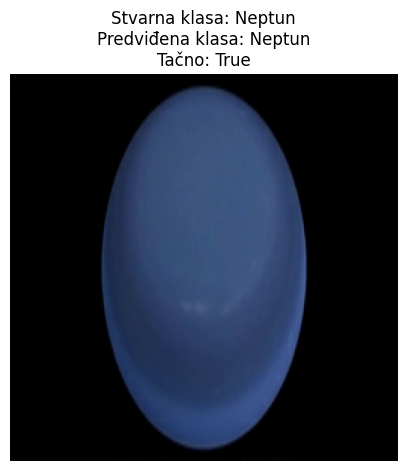

Stvarna klasa: Neptun, Predviđena klasa: Neptun, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


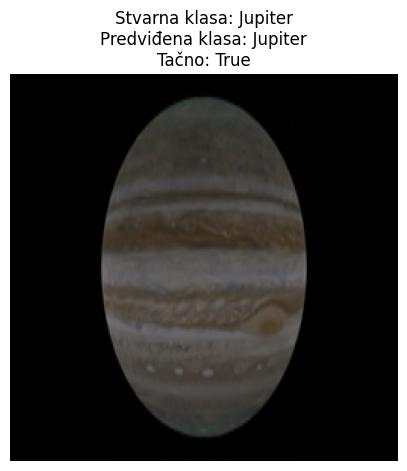

Stvarna klasa: Jupiter, Predviđena klasa: Jupiter, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


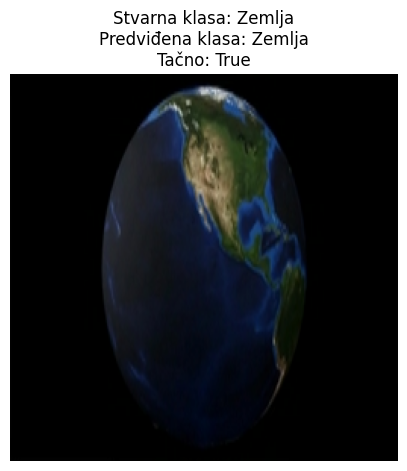

Stvarna klasa: Zemlja, Predviđena klasa: Zemlja, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


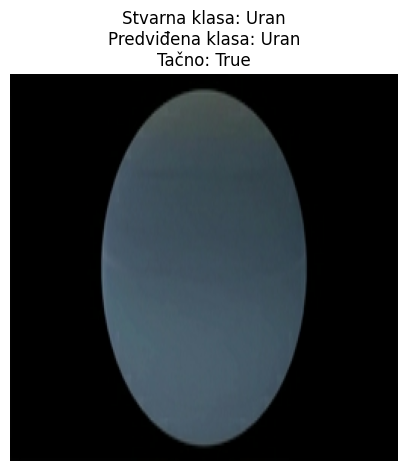

Stvarna klasa: Uran, Predviđena klasa: Uran, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


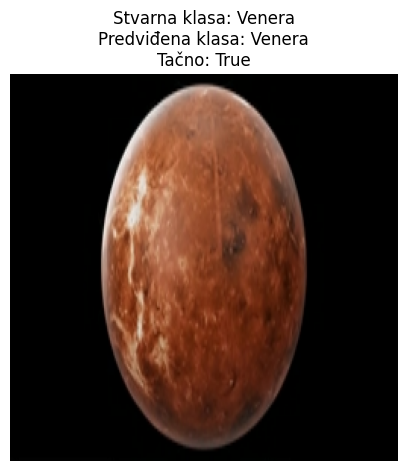

Stvarna klasa: Venera, Predviđena klasa: Venera, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


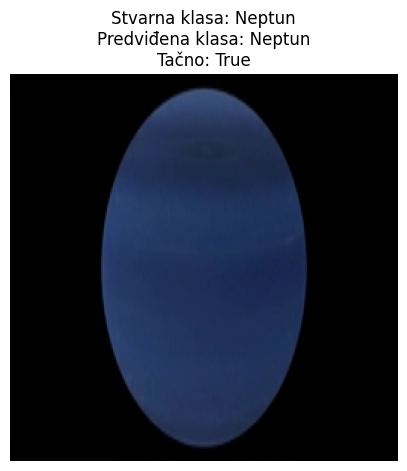

Stvarna klasa: Neptun, Predviđena klasa: Neptun, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


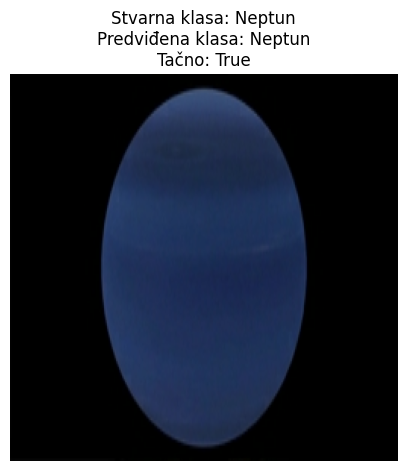

Stvarna klasa: Neptun, Predviđena klasa: Neptun, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


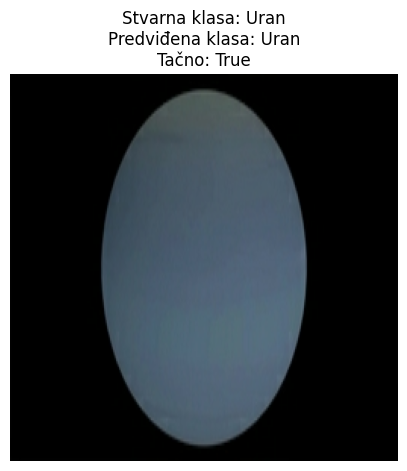

Stvarna klasa: Uran, Predviđena klasa: Uran, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


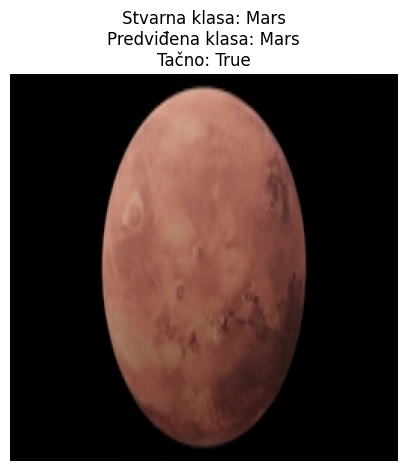

Stvarna klasa: Mars, Predviđena klasa: Mars, Tačno: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


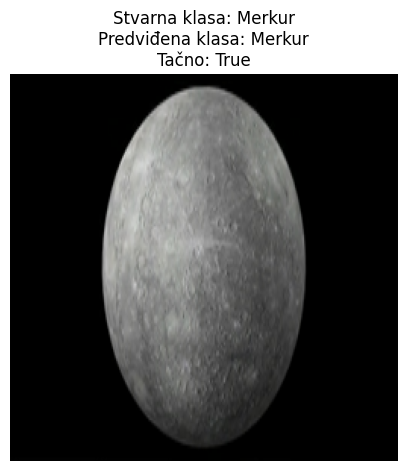

Stvarna klasa: Merkur, Predviđena klasa: Merkur, Tačno: True
Procenat tačnosti: 100.00%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ekstrakcija slika i labela iz test dataset-a
test_images = []
test_labels = []
for images, labels in test_ds.unbatch().take(30):  # Uzimanje prvih 30 slika i njihovih labela
    test_images.append(images.numpy())             # Pretvaranje slika iz tensora u numpy nizove
    test_labels.append(labels.numpy())             # Pretvaranje labela iz tensora u numpy nizove

# Nasumični izbor 10 slika iz test skupa za evaluaciju
indices = np.random.choice(range(len(test_images)), 10, replace=False)

# Inicijalizacija promenljivih za evidenciju tačnosti predviđanja
tacna_predikcija = 0
ukupno_predikcija = 0

for i in indices:
    img = test_images[i]                            # Uzimanje slike
    true_label_index = test_labels[i]               # Uzimanje indeksa stvarne labele
    true_label = imena_klasa[true_label_index]      # Dobijanje naziva stvarne klase

    # Normalizacija slike za prikaz ako nije u opsegu 0-1
    img_to_show = img
    if img_to_show.max() > 1.0:
        img_to_show = img_to_show / 255.0

    # Priprema slike za model dodavanjem batch dimenzije
    img_array = np.expand_dims(img, axis=0)                 # Dodaje se nova dimenzija
    prediction = model.predict(img_array)                   # Pravljenje predikcije
    predicted_class_index = np.argmax(prediction)           # Uzimanje indeksa sa najvišom vrednošću
    predicted_class = imena_klasa[predicted_class_index]    # Dobijanje naziva predviđene klase

    # Proveravanje tačnosti predviđanja
    is_correct = true_label == predicted_class
    if is_correct:
        tacna_predikcija += 1        # Ažuriranje broja tačnih predviđanja
    ukupno_predikcija += 1              # Ažuriranje ukupnog broja predviđanja

    # Prikaz slike, stvarne i predviđene klase
    plt.figure(figsize=(5, 6))
    plt.imshow(img_to_show)     # Prikaz slike
    plt.title(f"Stvarna klasa: {true_label}\nPredviđena klasa: {predicted_class}\nTačno: {is_correct}")
    plt.axis('off')             # Sklanjanje osi
    plt.show()                  # Prikazivanje slike

    # Ispis stvarne i predviđene klase u konzoli
    print(f"Stvarna klasa: {true_label}, Predviđena klasa: {predicted_class}, Tačno: {is_correct}")

# Izračunavanje i ispisivanje procenta tačnosti
preciznost_predikcije = (tacna_predikcija / ukupno_predikcija) * 100
print(f"Procenat tačnosti: {preciznost_predikcije:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-03-15 13:53:38.709041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

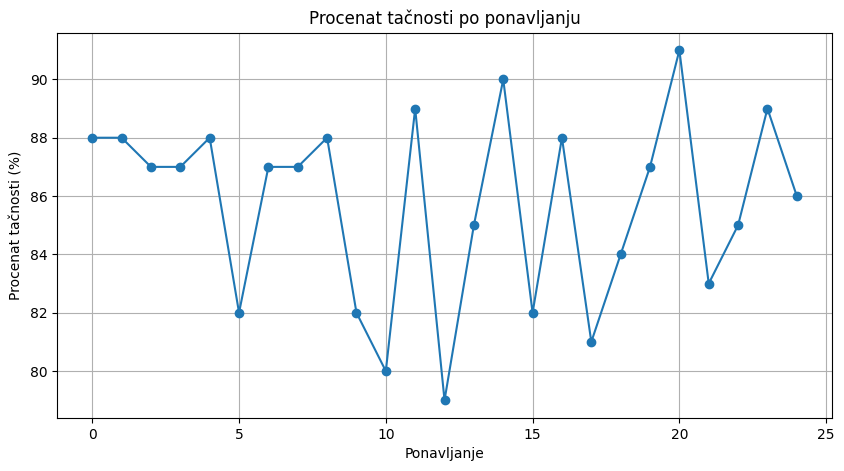

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Pretvaranje test_ds u listu slika i oznaka
test_images = []
test_labels = []
for images, labels in test_ds.unbatch().take(300):  # Uzmite 400 slika za testiranje
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Inicijalizacija liste za skladištenje procenata tačnosti
procenat_tacnost = []

# Ponovite testiranje 25 puta
for _ in range(25):
    # Izaberite 100 nasumičnih slika i njihove labele za testiranje
    indices = np.random.choice(range(len(test_images)), 100, replace=False)

    # Inicijalizacija brojača za tačna predviđanja i ukupan broj predviđanja
    tacna_predikcija = 0
    ukupno_predikcija = 0

    for i in indices:
        img = test_images[i]
        true_label_index = test_labels[i]
        true_label = imena_klasa[true_label_index]

        # Dodajte batch dimenziju i napravite predikciju
        img_array = np.expand_dims(img, axis=0)
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class = imena_klasa[predicted_class_index]

        # Provera da li je predviđena klasa tačna
        is_correct = true_label == predicted_class
        if is_correct:
            tacna_predikcija += 1
        ukupno_predikcija += 1

    # Izračunavanje i dodavanje procenta tačnosti u listu
    preciznost = (tacna_predikcija / ukupno_predikcija) * 100
    procenat_tacnost.append(preciznost)

# Crtanje grafika
plt.figure(figsize=(10, 5))
plt.plot(procenat_tacnost, marker='o')
plt.title('Procenat tačnosti po ponavljanju')
plt.xlabel('Ponavljanje')
plt.ylabel('Procenat tačnosti (%)')
plt.grid(True)
plt.show()


In [ ]:
Model se pokazao izuzetno brz i precizan
Za 10 epoha uspeo je da dostigne maksimalnu preciznost
Manji problem se javio na validacionom skupu gde je precizost stigla do 88%, a imali smo vise gubiataka, 
taj problem smo uspeli da resimo uz pomoc vestacko generisanih slika cime smo drasticno smanjili gubitke.

Program je pokrenut 25 puta na 100 nasumicnih slika i preciznost nije padala ispod 80%, sto nam pokazuje veliku preciznost,
narocito ako uzimamo u obzir da za odredjenje planete i satelite nismo imali dovoljno slika i odredjene nisu bile velikog kvaliteta
sto je ii razumno, jer su neke slike prikupljene 70tih godina kada je bila poslednja misija.

Takodje dosta objekata je tesko razlikovati i ljudskim okom, pa se moze reci da je preciznost na visokom nivou.
